<a href="https://colab.research.google.com/github/ccfernandes600/Sistema_Reconhecimento_Facial_do_Zero/blob/main/reconhecimento_facial_colab_e_Google_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepapração do Ambiente

Para executar o código, você precisa ter um ambiente Python configurado com as bibliotecas necessárias. O Google Colab é recomendado para facilitar a execução interativa do código. As principais bibliotecas utilizadas são:

- TensorFlow
- Keras
- NumPy
- OpenCV (cv2)
- Matplotlib
- PIL (Python Imaging Library)

No Google Colab, você pode instalar as bibliotecas necessárias com os seguintes comandos:


In [ ]:
#Instalar e importar as bibliotecas
#!pip install tensorflow numpy opencv-python matplotlib pillow
try:
  import numpy as np
  import cv2
  import os
  from sklearn.preprocessing import LabelEncoder
  from sklearn.model_selection import train_test_split
  from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
  from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.models import Model
  import matplotlib.pyplot as plt
  print(f'Bibliotecas importadas com sucesso!')
except ImportError as e:
  print(f'Erro ao importar bibliotecas: {e}')

Bibliotecas importadas com sucesso!


# Carregando e Pré-processando os Dados

Para um sistema de reconhecimento facial eficaz, precisamos de um conjunto de dados de faces. Vamos usar um conjunto de dados de exemplo, como o Labeled Faces in the Wild.

In [ ]:
#Montar pastas no google drive
try:
  from google.colab import drive
  drive.mount('/content/drive')
  print(f'Pastas montadas com sucesso!')
except Exception as e:
  print(f'Erro ao montar pastas: {e}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pastas montadas com sucesso!


In [ ]:
!ls -al /content/drive/MyDrive/conjunto_de_dados/

total 16
drwx------ 2 root root 4096 Jun 19 14:40 Claudio
drwx------ 2 root root 4096 Jun 19 14:43 Maria
drwx------ 2 root root 4096 Jun 19 14:55 Pedro
drwx------ 2 root root 4096 Jun 19 14:40 Rafaela


In [ ]:
def carregar_dados(diretorio, tamanho_imagem=(64, 64)):
    imagens = []
    labels = []
    for label in os.listdir(diretorio):
        path = os.path.join(diretorio, label)
        if os.path.isdir(path):
            for img in os.listdir(path):
                img_path = os.path.join(path, img)
                imagem = cv2.imread(img_path)
                if imagem is not None:
                    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
                    imagem = cv2.resize(imagem, tamanho_imagem)
                    imagem = img_to_array(imagem)
                    imagens.append(imagem)
                    labels.append(label)
    imagens = np.array(imagens, dtype="float") / 255.0
    return imagens, np.array(labels)

In [ ]:
# Carregar o conjunto de dados armazenados no meu Google Drive
try:
  diretorio_dados = '/content/drive/MyDrive/conjunto_de_dados/'
  imagens, labels = carregar_dados(diretorio_dados)
  print(f'Dados carregados com sucesso!')
  print(f'Imagens: {imagens.shape}')
  print(f'Labels: {labels.shape}')
except Exception as e:
  print(f'Erro ao carregar os dados: {e}')


Dados carregados com sucesso!
Imagens: (1451, 64, 64, 3)
Labels: (1451,)


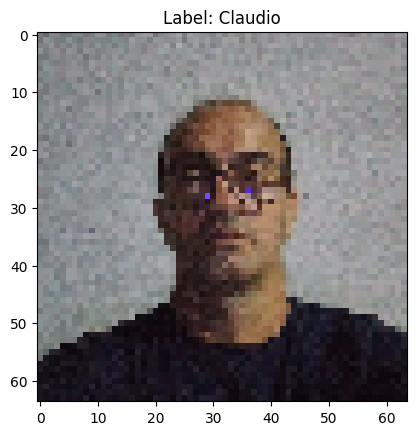

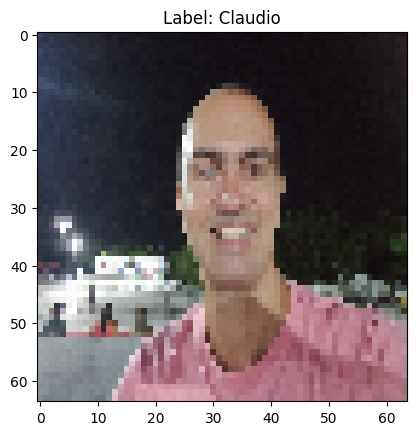

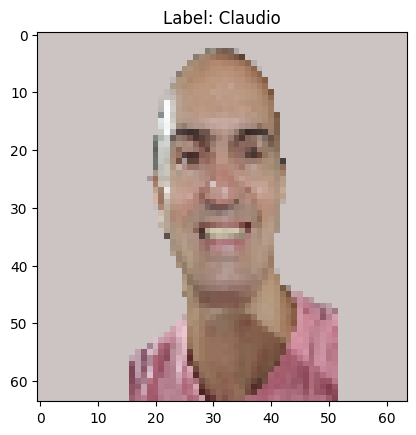

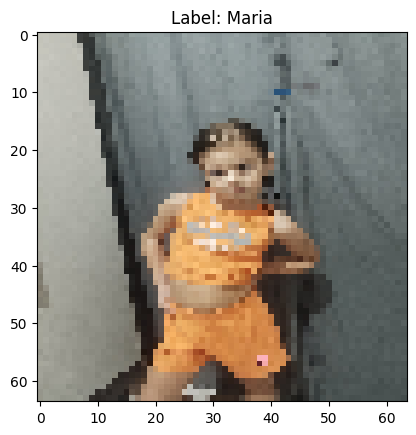

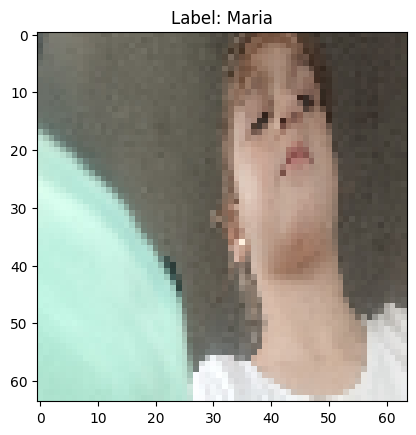

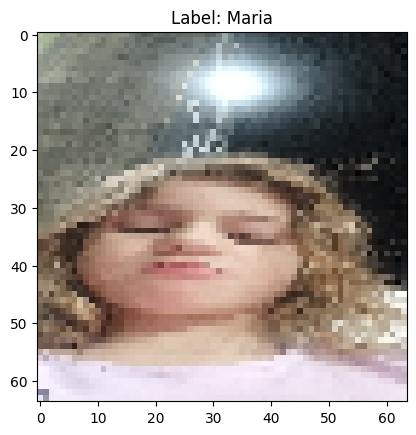

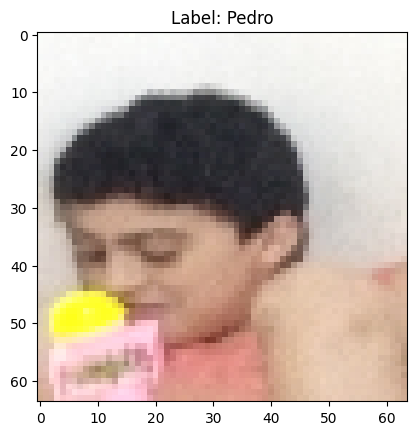

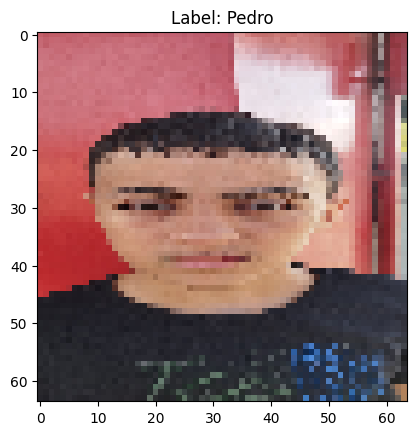

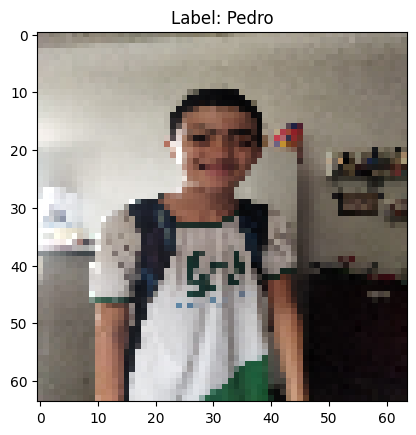

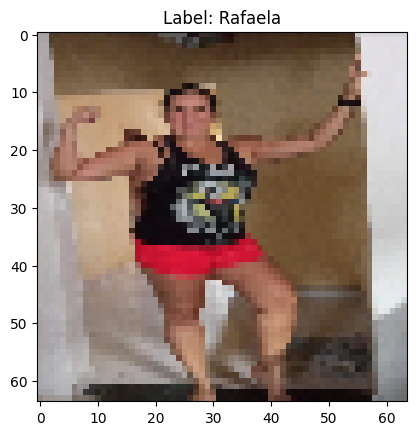

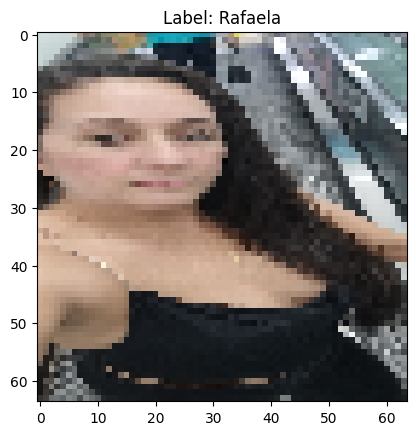

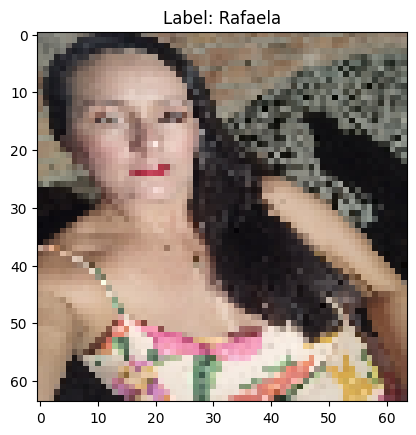

In [ ]:
# prompt: mostrar 03 images com com label de cada diretorio retornado pela função carregar_dados

def plot_images(images, labels, num_images=3):
  for i in range(num_images):
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.show()

# Plot the first 3 images from each directory
for label in np.unique(labels):
  indices = np.where(labels == label)[0][:3]
  plot_images(imagens[indices], labels[indices])


In [ ]:
# Codificar os rótulos
try:
  le = LabelEncoder()
  labels = le.fit_transform(labels)
  num_classes = len(np.unique(labels))
  labels = to_categorical(labels, num_classes)
  print(f'Labels codificados com sucesso!')
  print(f'Número de classes: {num_classes}')
except Exception as e:
  print(f'Erro ao codificar os rótulos: {e}')


Labels codificados com sucesso!
Número de classes: 4


In [ ]:
 #Dividir os dados em treinamento e teste
 try:
  x_train, x_test, y_train, y_test = train_test_split(imagens, labels, test_size=0.2, random_state=42)
  print(f'Dados divididos em treinamento e teste com sucesso!')
except Exception as e:
  print(f'Erro ao dividir os dados: {e}')


Dados divididos em treinamento e teste com sucesso!


In [ ]:
# Data Augmentation
try:
  datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )
  print(f'Data augmentation configurado com sucesso!')
except Exception as e:
  print(f'Erro ao configurar data augmentation: {e}')


Data augmentation configurado com sucesso!


In [ ]:
def load_and_prepare_model(model_choice, input_shape=(64, 64, 3)):
    """Loads a pre-trained model, freezes the base, and adds a classifier head."""

    models = {
        1: ResNet50,
        2: InceptionV3,
        3: MobileNetV2,
        4: DenseNet121,
        5: VGG16
    }

    base_model = models[model_choice](
        weights='imagenet', include_top=False, input_shape=input_shape
    )

    base_model.trainable = False  # Freeze the base layers for transfer learning

    # Add your own classifier head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your dataset
    if model_choice == 2:
      inputs= Input(shape=(75, 75, 3))
      model = Model(inputs, outputs=predictions)
    else:
      model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [ ]:
print("Choose a pre-trained model:")
print("1. ResNet50")
print("2. InceptionV3")
print("3. MobileNetV2")
print("4. DenseNet121")
print("5. VGG16")

choice = int(input("Entre com sua opçãp (1-5): "))
while choice not in [1, 2, 3, 4, 5]:
    print("Opção inválida. Por favor entre com um número entre 1 e 5.")
    choice = int(input("Entre com sua opção (1-5): "))
print(f"Você escolheu o modelo {choice}")
if choice == 2:
  input_shape=(75, 75, 3)
  print("input_shape=(75, 75, 3)")
else:
  input_shape=(64, 64, 3)
  print("input_shape=(64, 64, 3)")
# Carregue e prepare o modelo escolhido (Substitua 'num_classes' pelo valor correto)
try:
  # Carregar o modelo
  model = load_and_prepare_model(choice,input_shape )
  print(f'Modelo carregado com sucesso!')
except Exception as e:
  print(f'Erro ao carregar o modelo: {e}')
try:
  # Compile o modelo Escolha um otimizador e uma função de perda apropriados)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  print(f'Modelo compilado com sucesso!')
  model.summary()
except Exception as e:
  print(f'Erro ao compilar o modelo: {e}')


Choose a pre-trained model:
1. ResNet50
2. InceptionV3
3. MobileNetV2
4. DenseNet121
5. VGG16
Entre com sua opçãp (1-5): 5
Você escolheu o modelo 5
input_shape=(64, 64, 3)
Modelo carregado com sucesso!
Modelo compilado com sucesso!
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                        

In [ ]:
# Treinar o modelo
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    validation_data=(x_test, y_test),
                    epochs=20)

Epoch 1/20
37/37 [==============================] - 69s 2s/step - loss: 1.3631 - accuracy: 0.3448 - val_loss: 1.2829 - val_accuracy: 0.4124
Epoch 2/20
37/37 [==============================] - 78s 2s/step - loss: 1.2519 - accuracy: 0.4293 - val_loss: 1.2337 - val_accuracy: 0.4777
Epoch 3/20
37/37 [==============================] - 76s 2s/step - loss: 1.2151 - accuracy: 0.4397 - val_loss: 1.1643 - val_accuracy: 0.5086
Epoch 4/20
37/37 [==============================] - 79s 2s/step - loss: 1.1776 - accuracy: 0.4940 - val_loss: 1.1398 - val_accuracy: 0.5189
Epoch 5/20
37/37 [==============================] - 75s 2s/step - loss: 1.1468 - accuracy: 0.5181 - val_loss: 1.1334 - val_accuracy: 0.5361
Epoch 6/20
37/37 [==============================] - 76s 2s/step - loss: 1.1256 - accuracy: 0.5250 - val_loss: 1.1107 - val_accuracy: 0.5361
Epoch 7/20
37/37 [==============================] - 75s 2s/step - loss: 1.1069 - accuracy: 0.5371 - val_loss: 1.0927 - val_accuracy: 0.5567
Epoch 8/20
37/37 [==

# Avaliação do Modelo

In [ ]:
# Avaliar o modelo
if accuracy <= 0.9 :
  print('Acurácia não atingiu 90%')
  print("Modelo precisa de ajustes")
  loss, accuracy = model.evaluate(x_test, y_test)
  print(f'Loss: {loss}, Accuracy: {accuracy}')
else:
  print('Acurácia atingiu >= 90%')
  print("Modelo precisa precisade pequemos ajustes")
  loss, accuracy = model.evaluate(x_test, y_test)
  print(f'Loss: {loss}, Accuracy: {accuracy}')


Acurácia não atingiu 90%
Modelo precisa de ajustes
10/10 [==============================] - 13s 1s/step - loss: 1.0188 - accuracy: 0.6048
Loss: 1.018764853477478, Accuracy: 0.6048110127449036


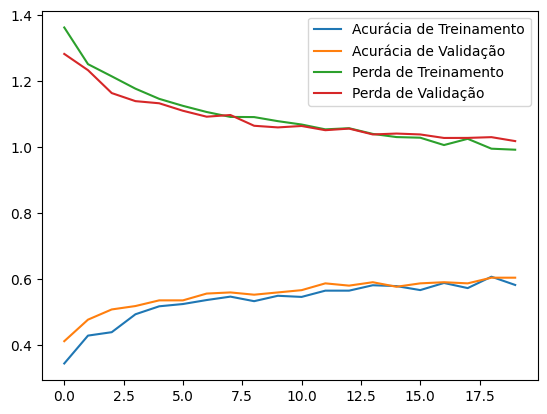

In [ ]:
# Plotar a precisão e a perda ao longo das épocas
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.legend()
plt.show()

# Detecção e Reconhecimento de Faces em uma Nova Imagem

Após treinar o modelo, podemos usá-lo para detectar e reconhecer faces em novas imagens.

Saving claudio2.jpg to claudio2 (1).jpg


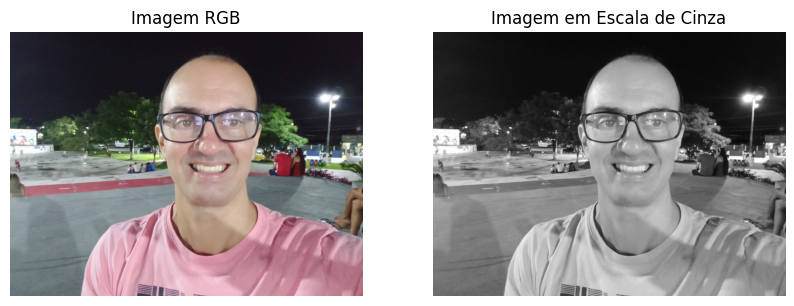

In [ ]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

# Fazer upload da imagem
uploaded = files.upload()

# Obter o nome do arquivo carregado
for filename in uploaded.keys():
    caminho_imagem = filename

# Carregar a imagem
imagem = cv2.imread(caminho_imagem)
if imagem is not None:
    # Converter para RGB
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    # Converter para escala de cinza
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    # Exibir a imagem
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title('Imagem RGB')
    plt.imshow(imagem_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Imagem em Escala de Cinza')
    plt.imshow(imagem_cinza, cmap='gray')
    plt.axis('off')

    plt.show()
else:
    print("Erro ao carregar a imagem.")


In [ ]:
# Detectar faces
classificador = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#faces = classificador.detectMultiScale(
#    imagem_cinza,
#    scaleFactor=1.1,  # Ajuste este valor conforme necessário
#    minNeighbors=5,   # Ajuste este valor conforme necessário
#    minSize=(300, 309), # Ajuste este valor conforme necessário
#    maxSize=(600, 600) # Ajuste este valor conforme necessário
#)
#faces = classificador.detectMultiScale(imagem_cinza, scaleFactor=1.1, minNeighbors=5)

faces = classificador.detectMultiScale(imagem_cinza, scaleFactor=1.2, minNeighbors=6)

# Aplicar NMS
if len(faces) > 0:
    indices = cv2.dnn.NMSBoxes(faces.tolist(), [1.0] * len(faces), 0.5, 0.4)
    if len(indices) > 0:
      faces = faces[indices.flatten()]  # Converter para array unidimensional

print(f'Faces detectadas: {len(faces)}')

Faces detectadas: 1


In [ ]:
#Imprimir labels das faces após NMS
print("Labels das faces reconhecidas:")
for (x, y, w, h) in faces:
    face = imagem_rgb[y:y + h, x:x + w]
    face = cv2.resize(face, (64, 64))
    face = face.astype("float") / 255.0
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0)
    prediction = model.predict(face)
    label = le.inverse_transform([np.argmax(prediction)])[0]
    print(label)

Labels das faces reconhecidas:
1/1 [==============================] - 0s 447ms/step
Claudio


In [ ]:
# Reconhecer faces
for (x, y, w, h) in faces:
    face = imagem_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (64, 64))
    face = face.astype("float") / 255.0
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0)
    prediction = model.predict(face)
    label = le.inverse_transform([np.argmax(prediction)])[0] # Corrigido para obter o label como string
    # Imprimir o label
    print("Label da foto:", label)
    # Desenhar retângulo e label na imagem
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 5  # Ajuste este valor para aumentar o tamanho da fonte
    font_thickness = 5
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = x + (w - text_size[0]) // 2
    text_y = y - 10
    cv2.rectangle(imagem_rgb, (x, y), (x+w, y+h), (255,0, 0), 4)
    #cv2.putText(imagem_rgb, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 3.0, (36,255,12), 2)
    cv2.putText(imagem_rgb, label, (text_x, text_y), font, font_scale, (255,0, 0), font_thickness)

cv2.waitKey(0)
cv2.destroyAllWindows()




1/1 [==============================] - 0s 135ms/step
Label da foto: Claudio


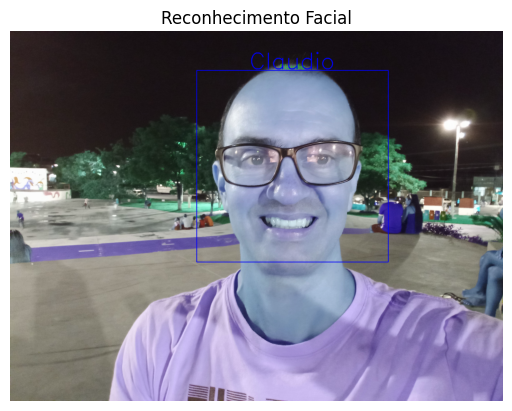

In [ ]:
# Exibir a imagem com os retângulos e labels
plt.imshow(cv2.cvtColor(imagem_rgb, cv2.COLOR_BGR2RGB))
plt.title("Reconhecimento Facial")
plt.axis('off')
plt.show()

# Próximos Passos

Este é um exemplo básico, mas você pode expandir o projeto para incluir mais funcionalidades, como:

Treinamento com mais dados e arquiteturas de redes mais complexas.
Implementação de técnicas de aumento de dados para melhorar a robustez do modelo.
Análise de expressões faciais e emoções.
Divirta-se explorando o mundo da visão computacional!

# Informações Adicionais
Projeto criado para fins de estudo junto com a DIO.me e o instrutor Diego Renan.